In [45]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

import gensim
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from spellchecker import SpellChecker

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

In [47]:
df_tweet_en = pd.read_pickle('df_tweet_en.p')

In [49]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    def space_uderscore(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        #return re.sub(r':([a-z&]+)_([a-z&]+):', r'\1\2', input_text)
        return input_text.replace('_',' ')
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(self.space_uderscore).apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [51]:
textcount = TextCounts()
df_eda = textcount.fit_transform(df_tweet_en.text)
# Add airline_sentiment to df_eda
df_eda['sentiment'] = df_tweet_en.sentiment
df_eda['origin_text'] = df_tweet_en.text
df_eda['likes'] =  df_tweet_en.likes
df_eda['retweets'] =  df_tweet_en.retweets

In [53]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
             count      mean        std  min   25%   50%   75%     max
sentiment                                                             
negative   20000.0  18.04060  10.465712  2.0  14.0  18.0  21.0  1002.0
neutral    20000.0  18.70125  26.951032  4.0  15.0  18.0  21.0  2755.0
positive   20000.0  18.18690  13.958625  2.0  14.0  18.0  22.0  1233.0


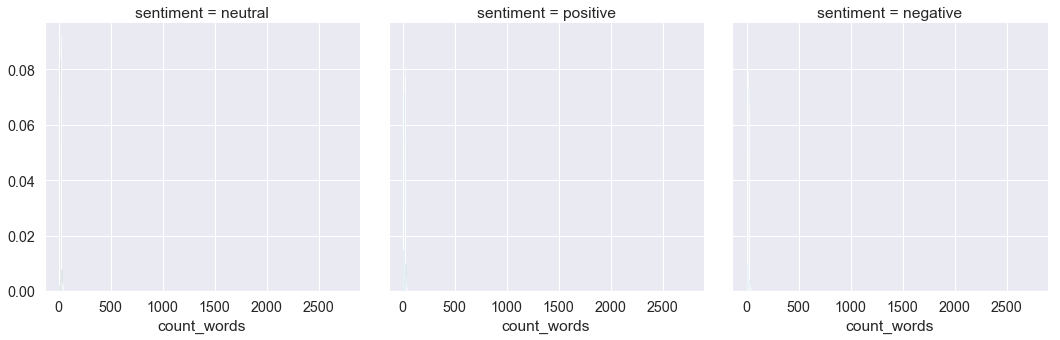

In [55]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_mentions
------------------------------------
             count     mean       std  min  25%  50%  75%   max
sentiment                                                      
negative   20000.0  0.34440  0.692541  0.0  0.0  0.0  1.0  20.0
neutral    20000.0  0.40075  0.785481  0.0  0.0  0.0  1.0  28.0
positive   20000.0  0.62965  1.007294  0.0  0.0  0.0  1.0  19.0


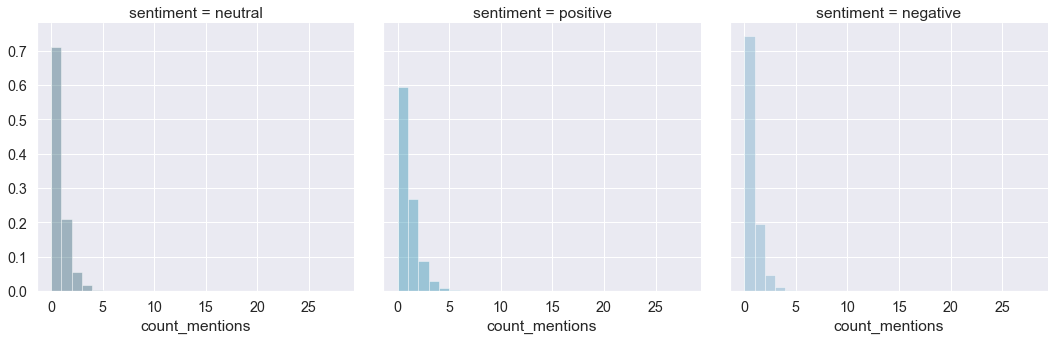

In [57]:
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
             count     mean       std  min  25%  50%  75%   max
sentiment                                                      
negative   20000.0  1.06350  1.394333  0.0  0.0  1.0  2.0  49.0
neutral    20000.0  1.97840  2.134470  0.0  1.0  2.0  3.0  90.0
positive   20000.0  2.04785  1.593734  0.0  1.0  2.0  3.0  73.0


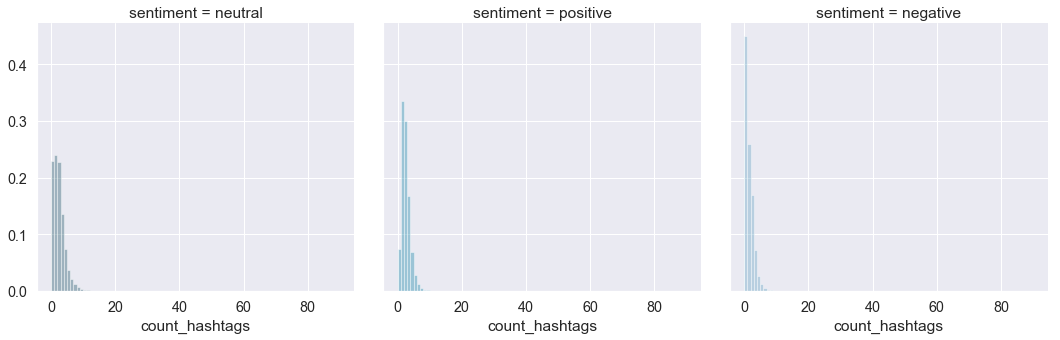

In [58]:
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
             count     mean       std  min  25%  50%  75%   max
sentiment                                                      
negative   20000.0  0.30060  0.882994  0.0  0.0  0.0  0.0  23.0
neutral    20000.0  0.45815  0.935464  0.0  0.0  0.0  1.0  32.0
positive   20000.0  0.33760  0.835441  0.0  0.0  0.0  0.0  22.0


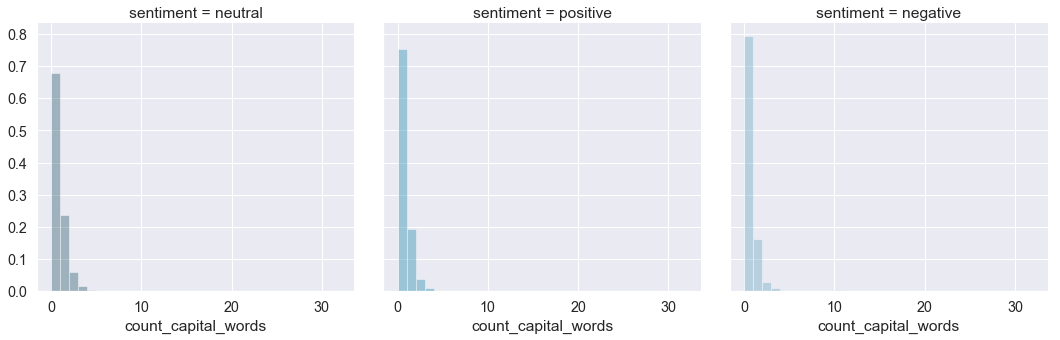

In [59]:
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
             count     mean       std  min  25%  50%  75%   max
sentiment                                                      
negative   20000.0  0.18910  0.495029  0.0  0.0  0.0  0.0  14.0
neutral    20000.0  0.22040  0.573969  0.0  0.0  0.0  0.0  23.0
positive   20000.0  0.39705  0.706559  0.0  0.0  0.0  1.0  18.0


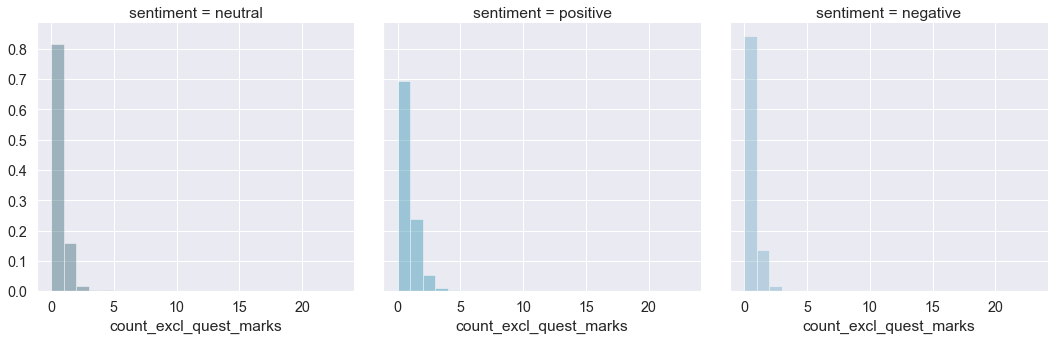

In [60]:
show_dist(df_eda, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
             count     mean       std  min  25%  50%  75%    max
sentiment                                                       
negative   20000.0  1.05395  0.769655  0.0  1.0  1.0  1.0  48.0 
neutral    20000.0  1.17985  1.541338  0.0  1.0  1.0  1.0  147.0
positive   20000.0  1.02795  0.898114  0.0  1.0  1.0  1.0  61.0 


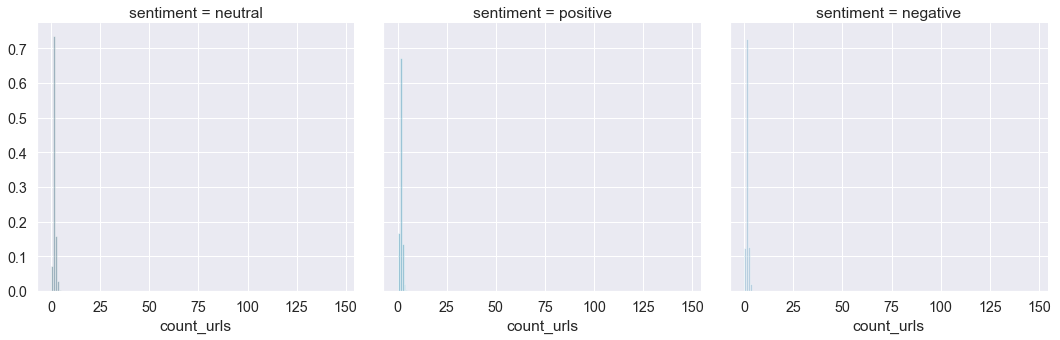

In [61]:
show_dist(df_eda, 'count_urls')

Descriptive stats for count_emojis
----------------------------------
             count     mean       std  min  25%  50%  75%   max
sentiment                                                      
negative   20000.0  0.00585  0.102060  0.0  0.0  0.0  0.0  6.0 
neutral    20000.0  0.01230  0.234630  0.0  0.0  0.0  0.0  17.0
positive   20000.0  0.01295  0.269046  0.0  0.0  0.0  0.0  21.0


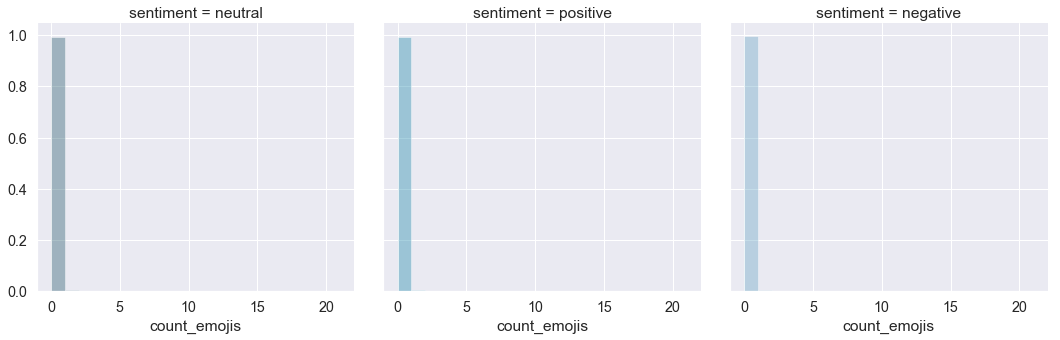

In [62]:
show_dist(df_eda, 'count_emojis')

In [63]:
class CleanText(BaseEstimator, TransformerMixin):
    
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    #def remove_hashtags(self, input_text):
        #return re.sub(r'#\w+', '', input_text)    
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        #return re.sub(r':([a-z&]+)_([a-z&]+):', r'\1\2', input_text)
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def replace_acronyms(self, input_text):
        acronyms_dic = {"B4" : "before","BFN":"bye for now","BGD" : "background","BH":"blockhead","BR":"best regards",
                        "BTW" : "by the way","OMG":"oh my god"}
        acronyms_pattern = re.compile(r'\b(' + '|'.join(acronyms_dic.keys()) + r')\b')
        return acronyms_pattern.sub(lambda x: acronyms_dic[x.group()], input_text)
        
    def stopwords_spell(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        blacklist = ["via","rt"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and (word not in blacklist) and len(word) > 1] 
        #correct words
        #spell = SpellChecker()
        correct_words = [word for word in clean_words]
        return " ".join(correct_words) 
    
    #def stemming(self, input_text):
        #porter = PorterStemmer()
        #words = input_text.split() 
        #stemmed_words = [porter.stem(word) for word in words]
        #return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.replace_acronyms).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.stopwords_spell)
        return clean_X

In [64]:
cleantext = CleanText()
sr_clean = cleantext.fit_transform(df_tweet_en.text)
sr_clean.sample(5)

3887045    join us april cxsummit amp miss talking cx amp iot                        
2298303    helped invent internet things here’s i’m worried secure crazy times outlet
3613033    getting ready iot’s bigdata challenges couchbase mobile                   
488075     internetofthings value shifts manufacturers embrace mfg                   
4717442    iot devices doomed cloud service discontinued amp                         
Name: text, dtype: object

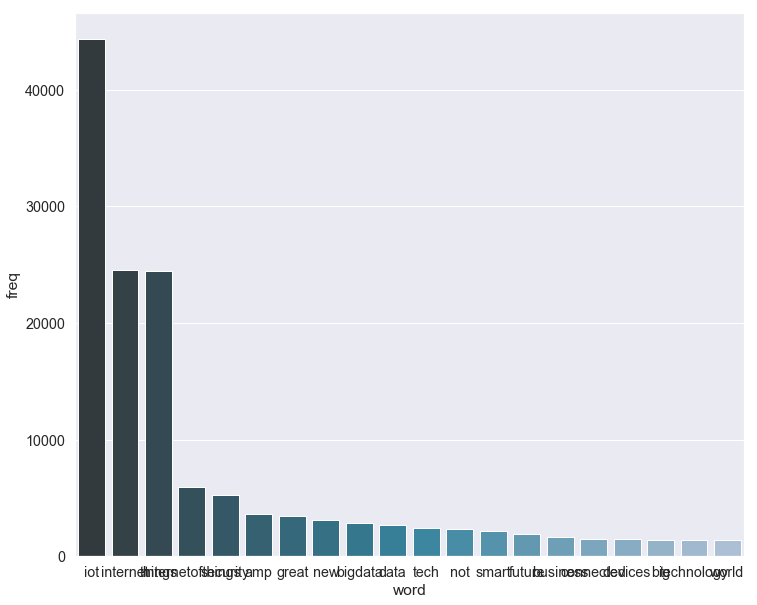

In [65]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

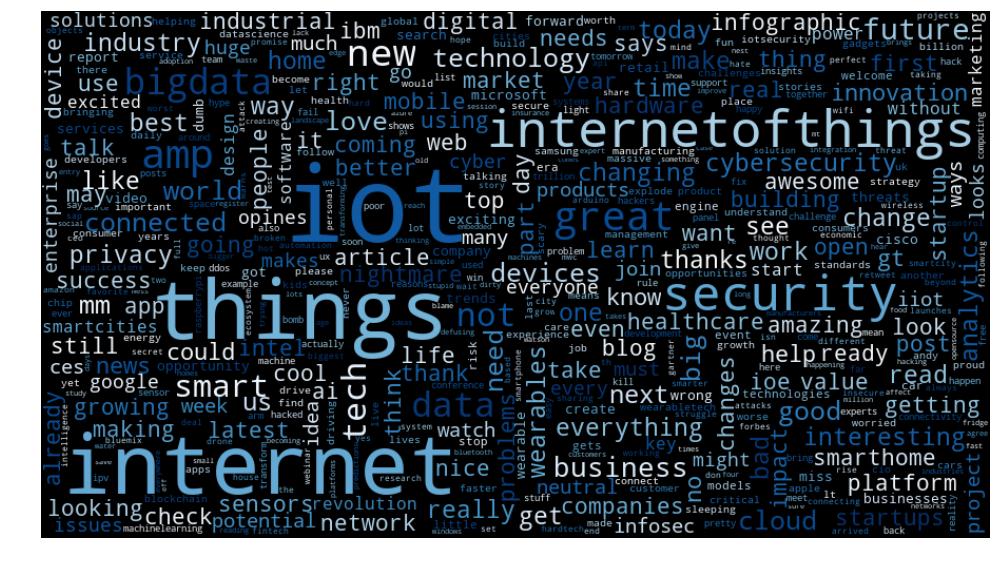

In [66]:
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(word_counter)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [67]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model = df_model.drop_duplicates('clean_text')

In [68]:
df_model.shape

(49526, 12)

In [69]:
df_model.info

<bound method DataFrame.info of          count_words  count_mentions  count_hashtags  count_capital_words  \
557219   20           1               1               0                     
5084791  21           1               4               0                     
4330044  15           0               1               0                     
4846444  17           0               0               0                     
1338071  14           0               2               0                     
4978301  14           0               2               0                     
823173   16           1               0               1                     
5206987  14           0               2               0                     
4722239  26           0               3               1                     
3206663  17           0               9               1                     
5706962  15           0               0               0                     
790092   14           0               0     

In [70]:
df_model['clean_text'].replace('', np.nan, inplace=True)

In [71]:
df_model = df_model.dropna(axis=0, subset=['clean_text'])
df_model.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,sentiment,origin_text,likes,retweets,clean_text
557219,20,1,1,0,1,1,0,neutral,5 ways Internet of things will create new opportunities for Indian businesses!Read here http://t.co/NiroT9Xa9I #DigitalUniverseIN @emcindia,0,0,ways internet things create new opportunities indian businesses read digitaluniversein
5084791,21,1,4,0,0,2,0,neutral,"As #bigdata, #cloud, and #IoT usage increases, so do #security concerns https://t.co/lXwuN7CP6s via @ITProPortal https://t.co/8KPv2ZbcuY",0,0,bigdata cloud iot usage increases security concerns
4330044,15,0,1,0,0,1,0,neutral,Hewlett Packard Enterprise Co Launches an Internet of Things Platform https://t.co/qf8qKwAhFs #iot,1,0,hewlett packard enterprise co launches internet things platform iot
4846444,17,0,0,0,0,1,0,neutral,"The Internet of Things is about to disrupt the digital economy, report says https://t.co/RFWzNYvNY1",0,1,internet things disrupt digital economy report says
1338071,14,0,2,0,0,1,0,neutral,How the #InternetOfThings is changing the World around Us http://t.co/iPz10oo7hc … #IoT,0,0,internetofthings changing world around us iot


In [72]:
df_model.to_pickle('df_model_without_stemming.p') # save dframe to pickle

In [73]:
positive_tweets = pd.Series(["My room is almost 100% fully automated. Almost every device can communicate with one another. I'm so in love. I love technology. #IoT"
                      ,"I love technology! The possibilities are endless. I can’t wait to publish my first paper! 👩🏽‍💻 #Software #computerscience #computationalthinking  #iot"
                      ,"Great question! I love the #aiot example from @VolvoTrucks - predicting maintenance issues using #IoT and #AI. (link: https://www.sas.com/en_us/customers/volvo-trucks-mack-trucks.html) sas.com/en_us/customer… "])

df_counts_pos = textcount.transform(positive_tweets)
df_clean_pos = cleantext.transform(positive_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos
df_model_pos.to_pickle('df_model_pos_stem.p')

In [74]:
negative_tweets = pd.Series(["I really hate what people are trying to do with #IoT. It's not even practical."
                      ,"I have a love/hate with the term IoT. Too broad in many ways, but it feels good that embedded, low power and purposeful devices are making headway in great directions. #iot’s time is now."
                      ,"I do not like #Iot because i hate"
                      ,"I hate the invasiveness of #IoT and I'm worried about @google's continued overt AND covert attempts to shut down speech with which their Far Left San Francisco values disagrees. But man do I love that #HomeAlone commercial. #UTvsUGA #GoDawgs"])

df_counts_neg = textcount.transform(negative_tweets)
df_clean_neg = cleantext.transform(negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg
df_model_neg.to_pickle('df_model_neg_stem.p')

In [75]:
df_model[df_model['sentiment'] == 'negative'].sample(n=30)

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,sentiment,origin_text,likes,retweets,clean_text
5650754,23,0,2,0,0,1,0,negative,IoT security: Maybe prevention should actually mean… prevention https://t.co/RRaWRY5kg8 &lt; Why network speed bumps &amp; #entsec won't work. #IoT,0,0,iot security maybe prevention actually mean… prevention lt network speed bumps amp entsec work iot
2776440,13,0,1,0,0,1,0,negative,4 IoT Cybersecurity Issues You Never Thought About http://t.co/rx1z2egTo5 #IoT,1,0,iot cybersecurity issues never thought iot
1858025,14,0,1,0,0,1,0,negative,Why #IoT is happening now. Over the past 10 years... http://t.co/cIsdYphqJx,0,1,iot happening past years
5438549,15,0,1,1,0,1,0,negative,#CYBERSECURITY Blame the Internet of Things for Destroying the Internet Today https://t.co/wS9P79Y4vB,1,0,cybersecurity blame internet things destroying internet today
1016581,16,2,2,0,1,1,0,negative,How does #IoT affect your business? @ZebraTechnology tells all at @BarcodingInc #ef4 http://t.co/HzcdKG8kFr,1,0,iot affect business tells ef
1934098,16,0,2,0,0,0,0,negative,awajeet: awajeet: awajeet: iotattack: awajeet: awajeet: HansB001: HansB001: Bluemix overview with Internet of Things #bluemix #IoT …,0,0,awajeet awajeet awajeet iotattack awajeet awajeet hansb hansb bluemix overview internet things bluemix iot
4685633,24,0,0,0,1,1,0,negative,Oops! Wearables can leak your PINs and passwords https://t.co/Ig0M16INbV The security nightmare posed by the Internet of Things isn’t jus…,0,0,oops wearables leak pins passwords security nightmare posed internet things isn’t jus…
3458317,27,0,2,1,0,3,0,negative,https://twitter.com/Absolutdata/status/687469441555263489/photo/1 RT Absolutdata The #internetofthings is not about the things https://t.co/RzLXl5S2mS staronline #Technology https://t.co/zgzkr3x7Vo,0,0,absolutdata internetofthings not things staronline technology
3223873,15,0,1,0,0,1,0,negative,Total Recall: Why IoT security is not an optional extra https://t.co/tdTLlcfjdJ #iotsecurity,0,0,total recall iot security not optional extra iotsecurity
905715,12,0,1,0,1,1,0,negative,The #InternetOfThings: What the Heck is a ‘Thing’? - http://t.co/gLeof0Xk0k,0,0,internetofthings heck ‘thing’
